In [1]:
import geopandas as gpd

In [2]:
cropfield = gpd.read_file("https://service.pdok.nl/rvo/brpgewaspercelen/atom/v1_0/downloads/brpgewaspercelen_definitief_2020.gpkg")

In [3]:
xmin, xmax = (120000, 135000)
ymin, ymax = (485000, 500000)
cropfield_crop = cropfield.cx[xmin:xmax, ymin:ymax]

In [4]:
cropfield_crop.to_file('cropped_field.shp')

/home/pchandramouli/anaconda3/envs/geospatial/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [5]:
cropfield_crop

,category,gewas,gewascode,jaar,status,geometry
425,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((126817.135 490421.657, 126854.917 49..."
426,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((127105.047 490650.143, 127114.115 49..."
427,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((125733.140 491490.013, 125734.276 49..."
428,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((127406.850 491022.697, 127366.501 49..."
429,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((126764.454 490332.958, 126767.180 49..."
...,...,...,...,...,...,...
771335,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((124031.517 492405.907, 124031.656 49..."
771365,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((127804.680 489832.254, 127793.056 48..."
771716,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((128964.168 499678.174, 128927.705 49..."
771776,Grasland,"Grasland, tijdelijk",266,2020,Definitief,"POLYGON ((120422.062 500006.597, 120433.608 50..."


In [6]:
import pystac
from pystac_client import Client
from shapely.geometry import Point
import rioxarray
import numpy as np
import earthpy.plot as ep
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from xrspatial import zonal_stats
import xarray as xr
import geopandas as gpd
import rasterio

In [8]:
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A, COGs
point = Point(4.89, 52.37)  # AMS coordinates

bbox = point.buffer(0.01).bounds

search = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2020-03-20/2020-03-30",
    query=["eo:cloud_cover<10"]
)
print(search.matched())

items = pystac.ItemCollection.from_file("search.json")

red_uri = items[1].assets["B04"].href
nir_uri = items[1].assets["B8A"].href

red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)

4


In [9]:
bbox = (629000, 5804000, 639000, 5814000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

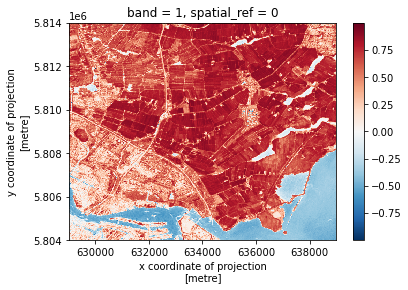

In [10]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)
ndvi = (nir_clip - red_clip_matched)/ (nir_clip + red_clip_matched)
ndvi.plot()
ndvi_sq = ndvi.squeeze()

In [11]:
cropfield_crop = gpd.read_file('cropped_field.shp')
cropfield_crop.crs

<Derived Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [12]:
cropfield_crs_raster = cropfield_crop.to_crs(ndvi.rio.crs)
cropfield_crs_raster.total_bounds
cropfield_crop.total_bounds

array([119594.384   , 484949.292625, 135375.77025 , 500782.531   ])

In [13]:
ndvi_sq.rio.bounds()

(629000.0, 5804000.0, 639000.0, 5814000.0)

In [14]:
cropfield_crs_raster.crs

<Derived Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
xmin, xmax = (629000, 639000)
ymin, ymax = (5804000, 5814000)
cropfield_crs_crop = cropfield_crs_raster.cx[xmin:xmax, ymin:ymax]
#cropfield_crs_crop.plot()
#cropfield_crs_crop.total_bounds
cropfield_crs_crop

,category,gewas,gewascode,jaar,status,geometry
0,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((634234.009 5807461.338, 634232.049 5..."
1,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((634514.198 5807699.177, 634504.207 5..."
2,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((633115.463 5808493.238, 633109.078 5..."
3,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((634803.514 5808081.449, 634809.802 5..."
4,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((634184.289 5807370.958, 634200.036 5..."
...,...,...,...,...,...,...
4864,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((632846.409 5811358.808, 632854.381 5..."
4865,Natuurterrein,Natuurterreinen (incl. heide),335,2020,Definitief,"POLYGON ((638144.387 5808851.932, 638089.278 5..."
4866,Natuurterrein,Natuurterreinen (incl. heide),335,2020,Definitief,"POLYGON ((638761.879 5808265.992, 638758.324 5..."
4867,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((631384.726 5809352.385, 631383.343 5..."


In [16]:

#geom = [shapes for shapes in cropfield_crop.geometry]
geom = cropfield_crs_crop[['geometry', 'gewascode']].values.tolist()
geom

[[<shapely.geometry.polygon.Polygon at 0x7f787aef8d90>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787aef8a00>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787c9d3c40>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787c9d30d0>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787c9c07f0>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787c9c0070>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787ac29e50>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787ac29ee0>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787ac29d30>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787ac29f10>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787ac29e80>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f787ac29e20>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f7879846490>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f7879846a00>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f78798469d0>, 265],
 [<shapely.geometry.polygon.Polygon at 0x7f7879846a30>, 265],
 [<shape

In [17]:
type(geom)

list

In [20]:
from rasterio import features 
cropfield_raster = rasterio.features.rasterize(geom, out_shape=ndvi_sq.shape, fill=0, transform=ndvi_sq.rio.transform())
type(cropfield_raster)
cropfield_raster_xarr = xr.DataArray(cropfield_raster)
#type(cropfield_raster_xarr)
#cropfield_raster_xarr.plot()

In [21]:
zstats = zonal_stats(cropfield_raster_xarr, ndvi_sq)
zstats

,zone,mean,max,min,sum,std,var,count
0,0,0.266531,0.999579,-0.998648,38887.648438,0.409970,0.168075,145903.0
1,259,0.520282,0.885242,0.289196,449.003052,0.111205,0.012366,863.0
2,265,0.775609,0.925955,0.060755,66478.976562,0.091089,0.008297,85712.0
3,266,0.794128,0.918048,0.544686,1037.925781,0.074009,0.005477,1307.0
4,331,0.703056,0.905304,0.142226,10725.819336,0.102255,0.010456,15256.0
5,332,0.681699,0.849158,0.178113,321.080261,0.123633,0.015285,471.0
6,335,0.648063,0.865804,0.239661,313.662598,0.146582,0.021486,484.0
7,863,0.388575,0.510572,0.185987,1.165724,0.144245,0.020807,3.0


In [18]:
import pandas as pd
code_type = cropfield_crs_crop[['gewascode', 'gewas']].drop_duplicates(ignore_index=True)
code_type_app = pd.DataFrame([[0, "non-crop"]], columns=['gewascode', 'gewas'])
code_type = pd.concat([code_type, code_type_app], ignore_index=True)
code_type = code_type.sort_values(by=['gewascode'], ignore_index=True)
code_type = code_type.drop(columns=['gewascode'])
code_type

,gewas
0,non-crop
1,"Maïs, snij-"
2,"Grasland, blijvend"
3,"Grasland, tijdelijk"
4,"Grasland, natuurlijk. Hoofdfunctie landbouw."
5,"Grasland, natuurlijk. Hoofdfunctie natuur."
6,Natuurterreinen (incl. heide)
7,Bos zonder herplantplicht


In [22]:
zstats = code_type.join(zstats)
zstats

,gewas,zone,mean,max,min,sum,std,var,count
0,non-crop,0,0.266531,0.999579,-0.998648,38887.648438,0.409970,0.168075,145903.0
1,"Maïs, snij-",259,0.520282,0.885242,0.289196,449.003052,0.111205,0.012366,863.0
2,"Grasland, blijvend",265,0.775609,0.925955,0.060755,66478.976562,0.091089,0.008297,85712.0
3,"Grasland, tijdelijk",266,0.794128,0.918048,0.544686,1037.925781,0.074009,0.005477,1307.0
4,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,0.703056,0.905304,0.142226,10725.819336,0.102255,0.010456,15256.0
5,"Grasland, natuurlijk. Hoofdfunctie natuur.",332,0.681699,0.849158,0.178113,321.080261,0.123633,0.015285,471.0
6,Natuurterreinen (incl. heide),335,0.648063,0.865804,0.239661,313.662598,0.146582,0.021486,484.0
7,Bos zonder herplantplicht,863,0.388575,0.510572,0.185987,1.165724,0.144245,0.020807,3.0
